In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from mypackages.eRDF import butter_lowpass_filter, DataProcessor
from tqdm import tqdm 
from mypackages.edp_processing import peak_calibration

from matplotlib import rcParams, cycler
from matplotlib.ticker import AutoMinorLocator

from mypackages.plot_style import set_plot_style

set_plot_style()

## Gold calibration automation

In [ ]:
#gold peak calibration
from scipy.signal import find_peaks

path = '/home/ABTLUS/victor.secco/data_processing/ED/Au/Au_13_jun_24/Au_inicio/'

#end_name = 'Au_end.csv'
start_name = 'Au_start.csv'

df1 = pd.read_csv(os.path.join(path, start_name), header = None)
#df2 = pd.read_csv(os.path.join(path, end_name), header = None)

data_start = df1[0].values
#data_end = df2[0].values

peaks_start, _ = find_peaks(data_start, distance = 40, height=300)
#peaks_end, _ = find_peaks(data_end, distance = 40, height=500)



calibration = peak_calibration(pixel_positions = peaks_start[3:7])
#calibration_end = peak_calibration(pixel_positions = peaks_end[1:5])

#calibration = (calibration_start +calibration_end)/2

#peaks_end, _ = find_peaks(data_end, distance = 1, height=500)

plt.plot(data_start)
plt.plot(df1[0].values)
plt.scatter(peaks_start[3:7], data_start[peaks_start[3:7]])
plt.show

In [ ]:
#Gr generation
lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED/Lobato_2014.txt'

ds = (calibration)/(2*math.pi) #AuNPs

CdSe =  {1: [34, 1], 2: [48, 1],}
Magnetite = {1: [26, 3], 2: [8, 4],}

path = '/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/CDSe_Inorg_Lig/'
df1 = pd.read_csv(os.path.join(path, 'CdSe_S2-.csv'), header=None)

raw_data = df1[120].values
start = int(raw_data.shape[0]*0.03)
end =  int(raw_data.shape[0]*0.8)


dp1 = DataProcessor(raw_data, 1,  lobato_path, start, end, ds, CdSe, region = 0.2)
 

_iq = dp1.iq
_sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0)
_fq_filtered = butter_lowpass_filter(_fq, fs = 50.0, cutoff = 2.0, order = 3)
_r, _Gr = dp1.calculate_Gr(_fq, rmax=80, dr=0.05)

_Gr_Lorch, _ = dp1.low_r_correction(_Gr, 0.025, _r, r_cut = 2)


dp1.plot_results(_sq, _fq, _Gr, _r, _Gr, 0)


In [ ]:
path = '/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/DATA/iq'

name_list = [x for x in os.listdir(path)]
name_list.sort()

iq_list = []

for name in name_list:
    df = pd.read_csv(os.path.join(path, name))
    iq = df.mean(axis=1).values
    iq_list.append(iq)


calibration = 0.00743649587727647
q = np.linspace(0, len(iq_list[0])*calibration, len(iq))


In [ ]:
fq_list = []

for iq in iq_list:
    start = int(iq.shape[0]*0.03)
    end =  int(iq.shape[0])
    from scipy.interpolate import splrep, splev

    # Perform spline fitting
    # tck contains the spline representation
    tck = splrep(q, iq, s=0)

    # Generate new x values for a smooth curve
    q_spline = np.arange(min(q), max(q), 0.001)

    # Evaluate the spline fit for the new x values
    iq_spline = splev(q_spline, tck)

    #Gr generation
    lobato_path = '/home/ABTLUS/victor.secco/data_processing/ED/Lobato_2014.txt'

    ds = (calibration)/(2*math.pi) #AuNPs

    CdSe =  {1: [34, 1], 2: [48, 1],}

    q_start, q_end = 1.49, 17.843
    indices = np.where((q_spline >= q_start) & (q_spline <= q_end))[0]

    dp1 = DataProcessor(iq, 0.8926770643, lobato_path, start, end, ds, CdSe, region = 0.3)
    

    _iq = dp1.iq
    _sq, _fq = dp1.calculate_SQ_PhiQ(_iq, 0)
    fq_list.append(_fq)

In [ ]:
len(fq_list)

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(15,5))

for i, fq in enumerate(fq_list):

    ax[i].plot(dp1.q, fq, label = name_list[i])
    ax[i].axhline(y=0, color='r', linestyle='dashed')
    ax[i].set_xlim([2,23])    
    ax[-1].set_xticks(np.arange(2, 23, step=5))    
    ax[i].set_yticks([])
    
 
plt.legend()
plt.show()

## Magnetite Calibration

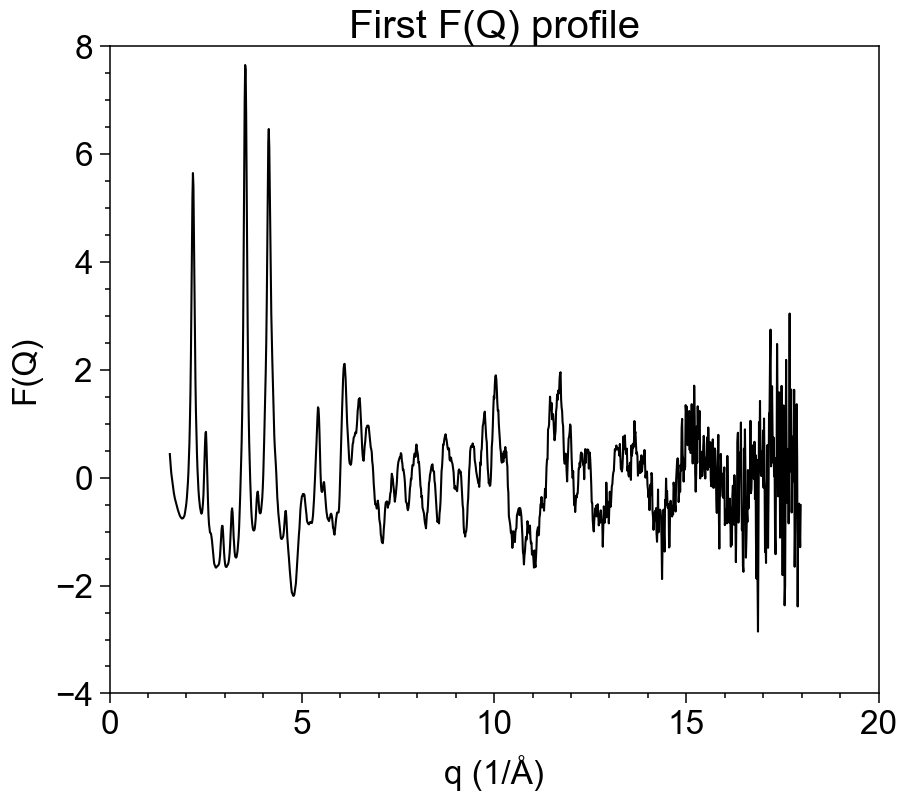

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks, butter, filtfilt

calibration = 0.01306302435277229 

# Load CSV file with 160 I(Q) columns
start_name = r"C:\Users\seccolev\data_processing\data\processed\ePDF\In2O3\20250708\iq_all_profiles_In2O3.csv"
df = pd.read_csv(start_name, header=None)

# ---------- Calibration ----------
start = 120
data_for_cal = df[0].values[start:]
peaks_start, _ = find_peaks(data_for_cal, distance=40, height=200, prominence=50)

# Manually pick 3 most prominent peaks for calibration

if calibration is None:
    subset = np.array([peaks_start[i] for i in [0, 1, 2]]) + start
    calibration = peak_calibration(pixel_positions=subset, standard=None,
                               peaks=[2.53224, 2.09963, 1.484659])  # Gold peaks

ds = calibration / (2 * math.pi)  # Convert to spacing in q-space
Elements = {1: [49, 1], 2: [8, 1]}  # Example for Magnetite

# ---------- F(Q) extraction loop ----------
fq_list = []
qmax = 18
rmax = 80
dr = 0.05
poly_degree = 8
use_filter = False  # Set to True to apply Butterworth filter

for col in df.columns:
    raw_data = df[col].values
    end = int(qmax / (ds * 2 * math.pi))
    end = min(end, raw_data.shape[-1])
    
    dp = DataProcessor(data=raw_data, q0=0, lobato_path=None,
                       start=start, end=end, ds=ds, Elements=Elements, region=0)

    iq = dp.iq
    sq, fq = dp.SQ_PhiQ(iq, 0)

    # Normalize
    norm_data = iq / (dp.N * dp.fq_sq)
    norm_data *= dp.q

    # Polynomial background subtraction
    coeffs = np.polyfit(dp.q, norm_data, poly_degree)
    poly_bg = np.poly1d(coeffs)(dp.q)
    fq_poly = norm_data - poly_bg

    # Optional filtering
    if use_filter:
        b, a = butter(3, 0.1, btype='low')
        fq_poly = filtfilt(b, a, fq_poly)

    fq_list.append(fq_poly)

# Stack all F(Q) columns into one DataFrame
fq_df = pd.DataFrame(fq_list).T
fq_df.columns = [f'fq_{i}' for i in range(len(fq_df.columns))]

# Optional: add q as index
fq_df.insert(0, "q", dp.q)

# Save
output_path = os.path.join(os.path.dirname(start_name), "fq_all_profiles.csv")

fq_df = fq_df.drop(fq_df.columns[1], axis=1)

fq_df.to_csv(output_path, index=False)

# Plot example
plt.plot(dp.q, fq_df['fq_90'])
plt.xlabel("q (1/Å)")
plt.ylabel("F(Q)")
plt.title("First F(Q) profile")
plt.show()


In [4]:
fq_df.head()

,q,fq_1,fq_2,fq_3,fq_4,fq_5,fq_6,fq_7,fq_8,fq_9,...,fq_110,fq_111,fq_112,fq_113,fq_114,fq_115,fq_116,fq_117,fq_118,fq_119
0,1.959454,-0.697428,-0.676990,-0.653300,-0.671263,-0.668722,-0.696240,-0.631854,-0.751987,-0.664799,...,0.014772,-0.053321,0.037928,-0.059067,0.010998,-0.119735,-0.022154,0.045742,-0.068958,-0.053731
1,1.972517,-0.680308,-0.669709,-0.644713,-0.663368,-0.662746,-0.683134,-0.626380,-0.734838,-0.656645,...,-0.001339,-0.061614,0.020456,-0.067959,0.003184,-0.124701,-0.034003,0.038105,-0.069957,-0.064608
2,1.985580,-0.658439,-0.647962,-0.628563,-0.642605,-0.642207,-0.652139,-0.608292,-0.709617,-0.636341,...,-0.007634,-0.072667,0.005537,-0.079969,-0.011557,-0.129714,-0.043235,0.018259,-0.072146,-0.072478
3,1.998643,-0.628854,-0.615326,-0.603121,-0.611279,-0.619945,-0.623965,-0.589654,-0.679420,-0.610087,...,-0.013628,-0.078554,-0.007627,-0.084197,-0.024741,-0.127087,-0.054290,0.004056,-0.081078,-0.072305
4,2.011706,-0.602360,-0.593822,-0.579617,-0.583504,-0.602174,-0.603013,-0.572996,-0.641716,-0.587724,...,-0.012403,-0.077982,-0.003361,-0.074877,-0.017395,-0.115666,-0.044098,0.008279,-0.075779,-0.060104


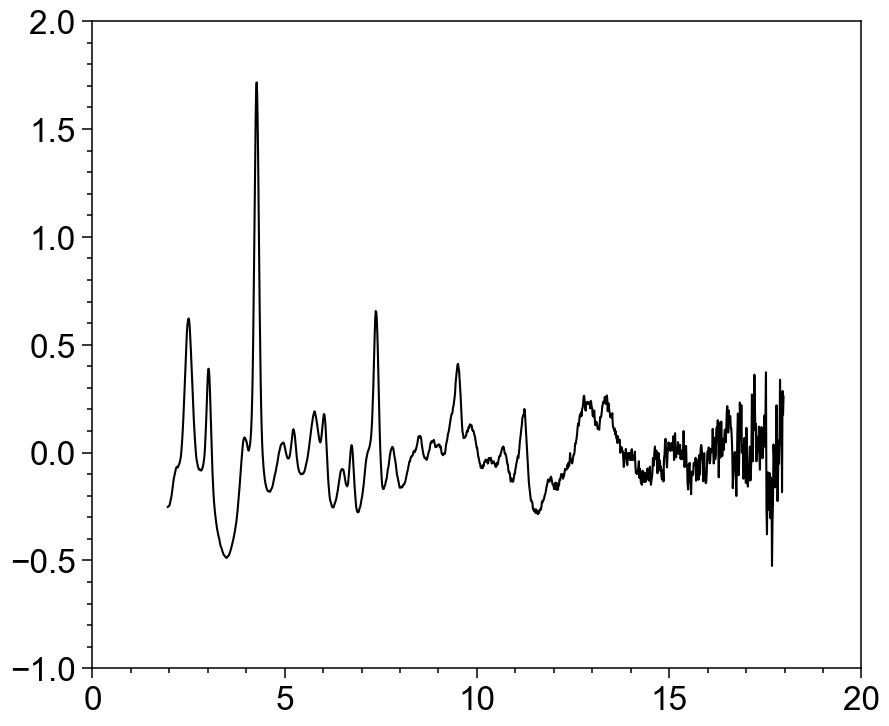

In [71]:
half_index = fq_df.shape[0]  # integer division for midpoint
fq_half = fq_df.iloc[:half_index]  # slice top half of the dataframe

mean_half = fq_half.drop(fq_half.columns[0], axis=1).mean(axis=1)

plt.plot(fq_half['q'].values, mean_half.values)


In [50]:
fq_df.columns

Index(['q', 'fq_1', 'fq_2', 'fq_3', 'fq_4', 'fq_5', 'fq_6', 'fq_7', 'fq_8',
       'fq_9',
       ...
       'fq_152', 'fq_153', 'fq_154', 'fq_155', 'fq_156', 'fq_157', 'fq_158',
       'fq_159', 'fq_160', 'fq_161'],
      dtype='object', length=162)